# SDG 15.3.1 Error Recode Script Example

This notebook demonstrates how to use the SDG 15.3.1 error recode script via the trends.earth API. The script supports both single-period and multi-period land degradation jobs and allows for recoding specific areas based on error polygons.

## 1. Setup Environment and Import Libraries

Before running this notebook, make sure you have:

1. **Installed dependencies**: `pip install -r requirements.txt`
2. **Created environment file**: Copy `.env.example` to `.env` and update with your credentials:
   ```bash
   cp .env.example .env
   ```
3. **Updated credentials** in the `.env` file:
   ```
   API_BASE_URL=https://api.trends.earth
   API_USERNAME=your_actual_username
   API_PASSWORD=your_actual_password
   ```

In [1]:
import json
import uuid
import warnings
from pprint import pprint

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Import the shared API client
from trendsearth_api import TrendsEarthAPIClient

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")
print("Environment variables loaded from .env file")

Libraries imported successfully!
Environment variables loaded from .env file


## 2. Configure API Connection and Authentication

In [2]:
# Initialize the API client
api_client = TrendsEarthAPIClient()

# Authenticate using environment variables from .env file
if api_client.authenticate_from_env():
    print("Ready to submit error recode jobs!")
    session = api_client.session  # For compatibility with existing code
else:
    print("Authentication failed - check your .env file")
    print("Please ensure your .env file contains:")
    print("- API_USERNAME=your_username")
    print("- API_PASSWORD=your_password")
    print("- API_BASE_URL=https://api.trends.earth (optional)")
    session = None

Using API URL from environment: https://api.trends.earth
Authenticating with Trends.Earth API...
   Using email: trends.earth-prais-server@trends.earth
Successfully authenticated with Trends.Earth API
Ready to submit error recode jobs!


## 3. Define Example Parameters for Error Recoding

### Error Recode Job Input Parameters

The SDG 15.3.1 error recode script accepts the following input parameters:

#### Core Job Parameters

- **`iso`** (string): ISO 3166-1 alpha-3 country code (e.g., "ATG" for Antigua and Barbuda)
- **`boundary_dataset`** (string): Administrative boundary dataset to use (e.g., "UN")
- **`write_tifs`** (boolean): Whether to write output as GeoTIFF files (`true` or `false`)
- **`aoi`** (object): Area of Interest as a GeoJSON polygon or feature collection

#### Error Polygons Structure

The **`error_polygons`** parameter must be a valid GeoJSON FeatureCollection with the following structure:

```json
{
    "type": "FeatureCollection",
    "name": "descriptive_name",
    "crs": {
        "type": "name",
        "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}
    },
    "features": [...]
}
```

#### Error Feature Properties

Each feature in the `error_polygons` collection supports these properties:

**Required Properties:**
- **`uuid`** (string): Unique identifier for the error polygon

- **`type`** (string): Must be "Feature"

- **`recode_deg_to`** (integer or null): What to recode degraded pixels to
  - `null` or `None`: No change (default)
  - `-32768`: No data
  - `0`: Stable
  - `1`: Improved

- **`recode_stable_to`** (integer or null): What to recode stable pixels to
  - `null` or `None`: No change (default)
  - `-32768`: No data
  - `-1`: Degraded
  - `1`: Improved

- **`recode_imp_to`** (integer or null): What to recode improved pixels to
  - `null` or `None`: No change (default)
  - `-32768`: No data
  - `-1`: Degraded
  - `0`: Stable

- **`periods_affected`** (array): List of periods to apply the recode to
  - `["baseline"]`: Apply to baseline period only
  - `["reporting_2"]`: Apply to reporting 2 only
  - `["baseline", "reporting_2"]`: Apply to multiple periods

**Descriptive Properties (Optional):**
- **`location_name`** (string): Human-readable name for the error area
- **`area_km_sq`** (number): Area of the polygon in square kilometers
- **`process_driving_change`** (string): Description of what caused the misclassification
- **`basis_for_judgement`** (string): Justification for making the correction


#### Geometry Requirements

Each error polygon feature must include a valid GeoJSON geometry:
- **`type`**: "Polygon"
- **`coordinates`**: Array of coordinate arrays defining the polygon boundary
- Coordinates should be in WGS84 (longitude, latitude) format

In [3]:
with open("ATG_polygon.geojson", "r") as f:
    atg_polygon = json.load(f)

params = {
    "iso": "ATG",
    "boundary_dataset": "UN",
    "write_tifs": True,
    "aoi": atg_polygon,  # Changed from json.dumps(atg_polygon) to atg_polygon
    "error_polygons": {
        "type": "FeatureCollection",
        "name": "test error recode",
        "crs": {
            "type": "name",
            "properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"},
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "uuid": str(uuid.uuid4()),
                    "location_name": "False degradation - mining misclassified",
                    "area_km_sq": 0.04,
                    "process_driving_change": "Open pit mining misclassified as degradation",
                    "basis_for_judgement": "Ground truth verification shows managed mining operation",
                    "recode_deg_to": 0,  # Recode degraded pixels to stable
                    "recode_stable_to": None,  # No change to stable pixels
                    "recode_imp_to": None,  # No change to improved pixels
                    "periods_affected": ["baseline"],
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [-61.85, 17.05],
                            [-61.8, 17.05],
                            [-61.8, 17.1],
                            [-61.85, 17.1],
                            [-61.85, 17.05],
                        ]
                    ],
                },
            },
            {
                "type": "Feature",
                "properties": {
                    "uuid": str(uuid.uuid4()),
                    "location_name": "Restoration success not captured",
                    "area_km_sq": 0.02,
                    "process_driving_change": "Successful restoration not detected by algorithm",
                    "basis_for_judgement": "Field monitoring shows vegetation recovery",
                    "recode_deg_to": 1,  # Recode degraded pixels to improved
                    "recode_stable_to": 1,  # Also recode stable pixels to improved
                    "recode_imp_to": None,  # Keep improved pixels as is
                    "periods_affected": ["baseline", "reporting_2"],
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [-61.82, 17.08],
                            [-61.78, 17.08],
                            [-61.78, 17.12],
                            [-61.82, 17.12],
                            [-61.82, 17.08],
                        ]
                    ],
                },
            },
            {
                "type": "Feature",
                "properties": {
                    "uuid": str(uuid.uuid4()),
                    "location_name": "Data quality issue",
                    "area_km_sq": 0.01,
                    "process_driving_change": "Cloud contamination in satellite data",
                    "basis_for_judgement": "Visual inspection shows persistent cloud cover",
                    "recode_deg_to": -32768,  # Set all to no data due to poor data quality
                    "recode_stable_to": -32768,  # Set all to no data
                    "recode_imp_to": -32768,  # Set all to no data
                    "periods_affected": ["reporting_2"],
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [-61.88, 17.15],
                            [-61.84, 17.15],
                            [-61.84, 17.18],
                            [-61.88, 17.18],
                            [-61.88, 17.15],
                        ]
                    ],
                },
            },
        ],
    },
}

## 4. Submit Job Execution to API

In [ ]:
if api_client.access_token:
    print(" Submitting error recode job...")
    execution_id = api_client.submit_job("sdg-15-3-1-error-recode-2-1-17", params)

    if execution_id:
        print("Job submitted. Monitoring job status...")

        # Monitor the job until completion
        final_status = api_client.monitor_job(execution_id, max_minutes=15)

        if final_status:
            status = final_status.get("status", "unknown").upper()
            if status in ["SUCCESS", "FINISHED"]:
                print("SUCCESS: Error recode job completed successfully!")

                # The results should be available in the job data
                results = final_status.get("results", {})
                if results:
                    print("Results available")
                    pprint(results)
                else:
                    print("No results data found in job response")
        else:
            print("ERROR: Failed to monitor job")
    else:
        print("ERROR: Failed to submit job")
else:
    print("ERROR: Cannot submit job: not authenticated")
    print("Please check your credentials and authentication")

 Submitting error recode job...
Job submitted. Monitoring job status...
Status: PENDING
Status: FINISHED
Job completed successfully!
SUCCESS: Error recode job completed successfully!
Results available
{'data': {'input_job': {'created': None,
                        'id': 'c540ef3d-293c-4d1c-be56-4c293856c06b',
                        'results_uri': '/vsis3/trends.earth-private/prais5-raw/ATG_UN_sdg-15-3-1-summary-2-1-17_TrendsEarth-LPD-5_UNCCD-legend_2000-2015-vs-2015-2019-vs-2015-2023_c540ef3d-293c-4d1c-be56-4c293856c06b_Int16.tif',
                        'task_name': 'ATG',
                        'task_notes': ''},
          'report': {'additional_summaries': [{'areas': [{'area': 60.15576047956228,
                                                          'name': 'Improved'},
                                                         {'area': 0.0,
                                                          'name': 'Stable'},
                                                         {'ar

Creating visualizations for error recode results...
Processing multi-band TIF file: /vsis3/trends.earth-users/prais5-recode/baefc443-c75e-4b5d-9777-966206818280_Int16.tif
Number of bands to visualize: 3
TIF file contains 3 bands
Real data statistics by band:
  Band 1 - SDG 15.3.1 Indicator - Baseline:
    No Data: 0.000 km² (84299 pixels)
    Degraded: 0.000 km² (1485 pixels)
    Stable: 0.000 km² (2862 pixels)
    Improved: 0.000 km² (870 pixels)
  Band 2 - SDG 15.3.1 Indicator - Reporting Period 2 Status:
    No Data: 0.000 km² (84324 pixels)
    Improved: 0.000 km² (826 pixels)
    Other (2): 0.000 km² (2117 pixels)
    Other (3): 0.000 km² (613 pixels)
    Other (4): 0.000 km² (1099 pixels)
    Other (5): 0.000 km² (158 pixels)
    Other (6): 0.000 km² (87 pixels)
    Other (7): 0.000 km² (292 pixels)
  Band 3 - Error recode:
    No Data: 0.000 km² (88732 pixels)
    Other (21): 0.000 km² (192 pixels)
    Other (32): 0.000 km² (336 pixels)
    Other (60): 0.000 km² (256 pixels)
NOT

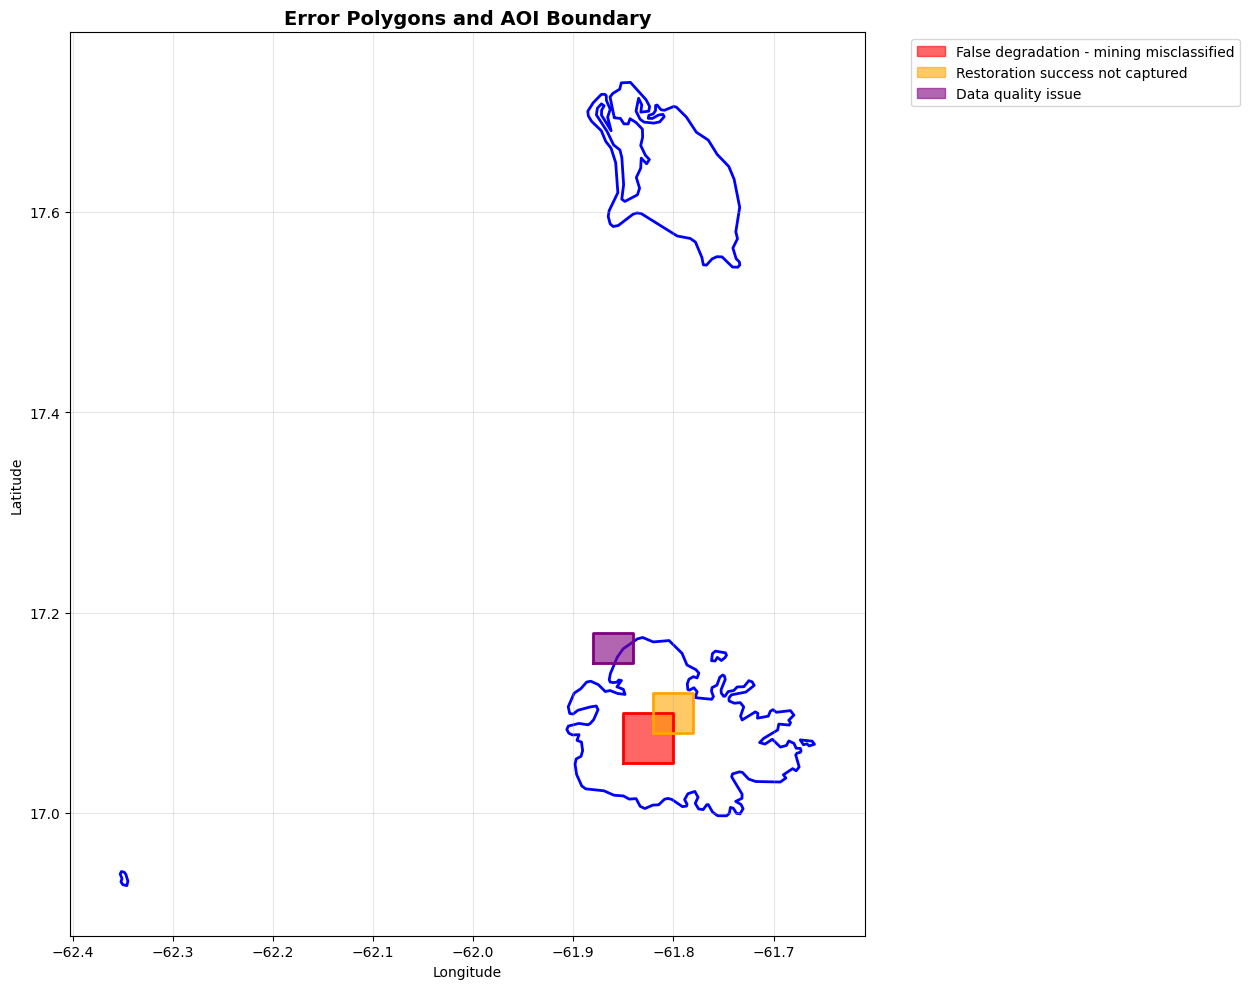

Creating visualizations for each band with appropriate SDG 15.3.1 color schemes...
Visualizing all 3 bands...


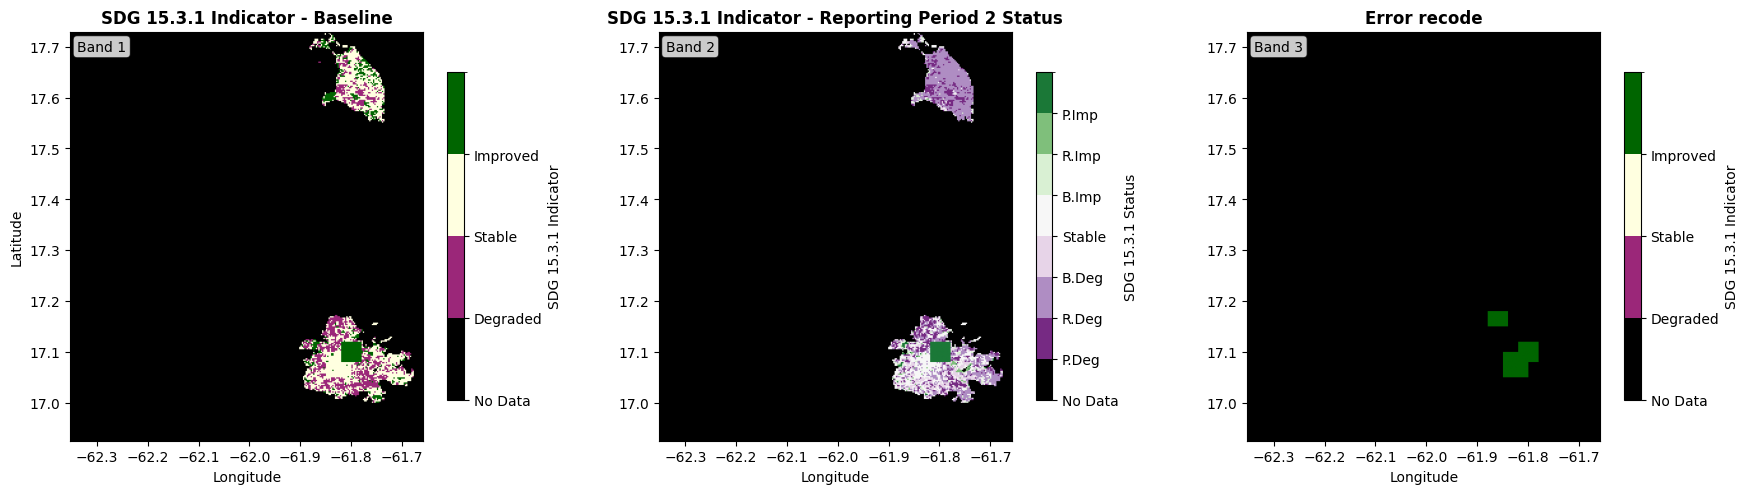

Summary of Error Recode Job:
Total error polygons processed: 3
Country: ATG
Output file: Multi-band TIF with 3 bands
All bands:
  Band 1: SDG 15.3.1 Indicator - Baseline
  Band 2: SDG 15.3.1 Indicator - Reporting Period 2 Status
  Band 3: Error recode
Error polygons:
  - False degradation - mining misclassified: 0.04 km² (affects: baseline)
  - Restoration success not captured: 0.02 km² (affects: baseline, reporting_2)
  - Data quality issue: 0.01 km² (affects: reporting_2)


In [ ]:
# The below code requires access to the s3 bucket where results are stored
# and will not run in the absence of valid credentials and a real job run.
# Can reformat to run on local data if desired.

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import shape

# Official SDG 15.3.1 color schemes from trends.earth styles.json
# SDG 15.3.1 Indicator (baseline style)
sdg_indicator_colors = {
    -32768: "#000000",  # nodata - black
    -1: "#9b2779",  # degraded - dark purple
    0: "#ffffe0",  # stable - light yellow
    1: "#006500",  # improved - dark green
}

# SDG 15.3.1 Indicator (status) - for status/progress visualizations
sdg_status_colors = {
    -32768: "#000000",  # nodata - black
    1: "#762a83",  # persistent degradation - dark purple
    2: "#af8dc3",  # recent degradation - medium purple
    3: "#e7d4e8",  # baseline degradation - light purple
    4: "#f7f7f7",  # stability - light gray
    5: "#d9f0d3",  # baseline improvement - light green
    6: "#7fbf7b",  # recent improvement - medium green
    7: "#1b7837",  # persistent improvement - dark green
}

print("Creating visualizations for error recode results...")

# Handle the actual results structure - multi-band TIF file
download_info = None
s3_uri = None
bands_info = []

# Extract URI and band information from results
if "uri" in results:
    download_info = results["uri"]

    # Extract the actual S3 URI from the nested structure
    if isinstance(download_info, dict) and "uri" in download_info:
        s3_uri = download_info["uri"]
    elif isinstance(download_info, str):
        s3_uri = download_info

# Extract band information from rasters section
if "rasters" in results:
    raster_data = results["rasters"]
    # Look for the Int16 raster type (or first available)
    for raster_type, raster_info in raster_data.items():
        if "bands" in raster_info:
            bands_info = raster_info["bands"]
            break

# For multi-band TIF, we use the single file with multiple bands
tif_file = s3_uri if s3_uri else None

if not tif_file:
    raise FileNotFoundError("ERROR: No TIF file URI found in results.")

print(f"Processing multi-band TIF file: {tif_file}")
print(f"Number of bands to visualize: {len(bands_info)}")

# Analyze each band for area statistics
error_polygons = params["error_polygons"]["features"]

try:
    with rasterio.open(tif_file) as src:
        print(f"TIF file contains {src.count} bands")

        # Get pixel size for area calculations
        pixel_area_m2 = abs(
            src.transform[0] * src.transform[4]
        )  # meters squared per pixel
        pixel_area_km2 = pixel_area_m2 / 1_000_000  # convert to km²

        print("Real data statistics by band:")
        for i, band_info in enumerate(bands_info, 1):
            if i <= src.count:
                # Read the band data
                data = src.read(i)

                # Validate data exists
                if data is None or data.size == 0:
                    print(f"  Band {i} ({band_info['name']}): No valid data")
                    continue

                # Calculate total areas for each class
                unique_values, counts = np.unique(data, return_counts=True)

                print(f"  Band {i} - {band_info['name']}:")
                for value, count in zip(unique_values, counts):
                    area_km2 = count * pixel_area_km2
                    if value == -32768:
                        print(f"    No Data: {area_km2:.3f} km² ({count} pixels)")
                    elif value == -1:
                        print(f"    Degraded: {area_km2:.3f} km² ({count} pixels)")
                    elif value == 0:
                        print(f"    Stable: {area_km2:.3f} km² ({count} pixels)")
                    elif value == 1:
                        print(f"    Improved: {area_km2:.3f} km² ({count} pixels)")
                    else:
                        print(
                            f"    Other ({value}): {area_km2:.3f} km² ({count} pixels)"
                        )

        print(
            "NOTE: Complete polygon-specific analysis requires masking TIF data with polygon geometries."
        )

except Exception as e:
    raise RuntimeError(f"ERROR: Failed to analyze multi-band TIF data: {str(e)}") from e

# STATIC MAP OF ERROR POLYGONS USING MATPLOTLIB
print("Creating static map with error polygons...")

# Get the center of the AOI for map centering
try:
    # Use the atg_polygon directly since it's the loaded AOI
    if isinstance(atg_polygon, dict):
        # Convert to GeoDataFrame for bounds calculation
        if "features" in atg_polygon:
            # It's a FeatureCollection
            aoi_gdf = gpd.GeoDataFrame.from_features(atg_polygon["features"])
        elif "geometry" in atg_polygon:
            # It's a single Feature
            aoi_gdf = gpd.GeoDataFrame.from_features([atg_polygon])
        else:
            # Assume it's a geometry
            aoi_gdf = gpd.GeoDataFrame([{"geometry": shape(atg_polygon)}])

        bounds = aoi_gdf.total_bounds  # Get bounds as [minx, miny, maxx, maxy]
        center_lat = (bounds[1] + bounds[3]) / 2  # (miny + maxy) / 2
        center_lon = (bounds[0] + bounds[2]) / 2  # (minx + maxx) / 2
    else:
        raise ValueError("AOI is not a dictionary")
except Exception as e:
    # Default to Antigua and Barbuda center
    center_lat, center_lon = 17.0608, -61.7964
    bounds = [-62.5, 16.5, -61.5, 17.5]  # rough ATG bounds

# Create matplotlib map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot AOI boundary
try:
    aoi_gdf.plot(
        ax=ax,
        facecolor="none",
        edgecolor="blue",
        linewidth=2,
        label=f"AOI: {params['iso']}",
    )
except:
    # Fallback if AOI plotting fails
    ax.plot(
        [bounds[0], bounds[2], bounds[2], bounds[0], bounds[0]],
        [bounds[1], bounds[1], bounds[3], bounds[3], bounds[1]],
        "b-",
        linewidth=2,
        label=f"AOI: {params['iso']}",
    )

# Plot error polygons with different colors
colors = ["red", "orange", "purple", "green", "pink"]
for i, polygon in enumerate(error_polygons):
    color = colors[i % len(colors)]
    location_name = polygon["properties"].get("location_name", f"Error Polygon {i + 1}")

    # Convert polygon to shapely geometry
    poly_geom = shape(polygon["geometry"])

    # Create matplotlib polygon
    if poly_geom.geom_type == "Polygon":
        coords = list(poly_geom.exterior.coords)
        x_coords, y_coords = zip(*coords)
        ax.fill(x_coords, y_coords, color=color, alpha=0.6, label=location_name)
        ax.plot(x_coords, y_coords, color=color, linewidth=2)

# Set map properties
ax.set_xlim(bounds[0] - 0.05, bounds[2] + 0.05)
ax.set_ylim(bounds[1] - 0.05, bounds[3] + 0.05)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Error Polygons and AOI Boundary", fontsize=14, fontweight="bold")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, alpha=0.3)

# Add coordinate labels
ax.tick_params(axis="both", which="major", labelsize=10)

plt.tight_layout()
plt.show()

# 3. MULTI-BAND TIF FILE VISUALIZATIONS
print(
    "Creating visualizations for each band with appropriate SDG 15.3.1 color schemes..."
)

# FAIL HARD: Require real TIF file - no fallbacks or examples
if not tif_file:
    raise FileNotFoundError(
        "ERROR: No TIF file found. Real data is required for visualization."
    )

if not bands_info:
    raise ValueError(
        "ERROR: No band information found. Cannot proceed without band metadata."
    )

# Filter to all bands for visualization
all_bands = [(i + 1, band) for i, band in enumerate(bands_info)]

if not all_bands:
    raise ValueError("ERROR: No bands found for visualization.")

print(f"Visualizing all {len(all_bands)} bands...")

# Create subplot layout for all bands
n_bands = len(all_bands)
cols = min(n_bands, 3)  # Maximum 3 columns
rows = (n_bands + cols - 1) // cols  # Calculate required rows
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))

# Handle single subplot case
if n_bands == 1:
    axes = [axes]
elif rows == 1 and cols > 1:
    axes = axes
else:
    axes = axes.flatten() if n_bands > 1 else [axes]

try:
    with rasterio.open(tif_file) as src:
        for plot_idx, (band_idx, band_info) in enumerate(all_bands):
            # Read the band data
            data = src.read(band_idx)

            # Validate data
            if data is None or data.size == 0:
                raise ValueError(
                    f"ERROR: Empty or invalid data in band {band_idx}: {band_info['name']}"
                )

            # Replace specific nodata values
            nodata_value = band_info.get("no_data_value", -32768)
            data = np.where(data == src.nodata, nodata_value, data)

            # Determine color scheme based on band name and metadata
            band_name = band_info["name"].lower()
            period = band_info.get("metadata", {}).get("period", "")

            if "status" in band_name:
                # Use SDG status color scheme for status bands
                color_scheme = sdg_status_colors
                color_label = "SDG 15.3.1 Status"
                # Create colormap for status values (1-7)
                status_values = sorted([k for k in color_scheme.keys() if k != -32768])
                colors_list = [color_scheme[-32768]] + [
                    color_scheme[v] for v in status_values
                ]
                bounds = [-32768] + status_values + [status_values[-1] + 1]
                tick_labels = [
                    "No Data",
                    "Persistent Deg.",
                    "Recent Deg.",
                    "Baseline Deg.",
                    "Stable",
                    "Baseline Imp.",
                    "Recent Imp.",
                    "Persistent Imp.",
                ]
                ticks = [-32768] + status_values
            else:
                # Use SDG indicator color scheme for baseline/regular bands
                color_scheme = sdg_indicator_colors
                color_label = "SDG 15.3.1 Indicator"
                colors_list = [
                    color_scheme[-32768],
                    color_scheme[-1],
                    color_scheme[0],
                    color_scheme[1],
                ]
                bounds = [-32768, -1, 0, 1, 2]
                tick_labels = ["No Data", "Degraded", "Stable", "Improved"]
                ticks = [-32768, -1, 0, 1]

            # Create colormap
            cmap = ListedColormap(colors_list)
            norm = BoundaryNorm(bounds, cmap.N)

            # Plot the band
            im = axes[plot_idx].imshow(
                data,
                cmap=cmap,
                norm=norm,
                extent=[
                    src.bounds.left,
                    src.bounds.right,
                    src.bounds.bottom,
                    src.bounds.top,
                ],
            )

            # Set title and labels
            axes[plot_idx].set_title(band_info["name"], fontsize=12, fontweight="bold")
            axes[plot_idx].set_xlabel("Longitude")
            if plot_idx % cols == 0:  # First column gets y-label
                axes[plot_idx].set_ylabel("Latitude")

            # Add colorbar for each subplot
            cbar = plt.colorbar(im, ax=axes[plot_idx], ticks=ticks, shrink=0.8)
            if "status" in band_name:
                # Abbreviated labels for status colorbar due to space
                cbar.set_ticklabels(
                    [
                        "No Data",
                        "P.Deg",
                        "R.Deg",
                        "B.Deg",
                        "Stable",
                        "B.Imp",
                        "R.Imp",
                        "P.Imp",
                    ]
                )
            else:
                cbar.set_ticklabels(tick_labels[: len(ticks)])
            cbar.set_label(color_label, fontsize=10)

            # Add band number info
            axes[plot_idx].text(
                0.02,
                0.98,
                f"Band {band_idx}",
                transform=axes[plot_idx].transAxes,
                verticalalignment="top",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            )

except Exception as e:
    raise RuntimeError(f"ERROR: Failed to process multi-band TIF file: {str(e)}") from e

# Hide any unused subplots
for i in range(n_bands, len(axes)):
    if i < len(axes):
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# 4. SUMMARY STATISTICS
print("Summary of Error Recode Job:")
print(f"Total error polygons processed: {len(error_polygons)}")
print(f"Country: {params['iso']}")
if tif_file:
    print(f"Output file: Multi-band TIF with {len(bands_info)} bands")
    print("All bands:")
    for i, band in enumerate(bands_info, 1):
        print(f"  Band {i}: {band['name']}")
else:
    print("Output files: No TIF file available")

print("Error polygons:")
for i, polygon in enumerate(error_polygons):
    name = polygon["properties"].get("location_name", f"Polygon {i + 1}")
    area = polygon["properties"].get("area_km_sq", "Unknown")
    periods = polygon["properties"].get("periods_affected", [])
    print(f"  - {name}: {area} km² (affects: {', '.join(periods)})")